In [1]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import utils
from model01 import MLPModel01
from metrics import performance_report
import datasets

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import keras
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_curve, confusion_matrix

Using TensorFlow backend.


In [2]:
n_categories = 2 # implicit in prepare_data (maybe parameterise)
lookahead = 1
window = 25
sym = 'USDJPY'
dataset_name = 'DS2'

In [3]:
X_train, Y_train, prices_train, fut_return_train = \
    datasets.load(datasets.filename(dataset_name, lookahead, window, sym, 2009))

X_dev, Y_dev, prices_dev, fut_return_dev = \
    datasets.load(datasets.filename(dataset_name, lookahead, window, sym, 2010))

    # sample 50k records from 2010 as dev set
dev_idx = np.random.choice(len(X_dev), 50000, replace=False)
X_dev, Y_dev, prices_dev, fut_return_dev = \
    X_dev.ix[dev_idx], Y_dev.ix[dev_idx], prices_dev.ix[dev_idx], fut_return_dev.ix[dev_idx]

X_test, Y_test, prices_test, fut_return_test = \
    datasets.load(datasets.filename(dataset_name, lookahead, window, sym, 2011))

In [4]:
print("train", X_train.shape)
print("dev", X_dev.shape)
print("test", X_test.shape)
n_features = X_train.shape[1]
print ("n_features:", n_features)

train (334974, 99)
dev (50000, 99)
test (291804, 99)
n_features: 99


In [5]:
# from sklearn.linear_model import SGDClassifier
# lin_model = SGDClassifier(loss='hinge', penalty='l2', n_iter=200, n_jobs=10)
# lin_model.fit(X_train.as_matrix(), Y_train)

# print( "train f1", f1_score(Y_train, lin_model.predict(X_train), average='weighted') )
# print( "test f1", f1_score(Y_test, lin_model.predict(X_test), average='weighted'))

In [ ]:
# from sklearn.linear_model import LogisticRegression
# lr_model = LogisticRegression(n_jobs=10)
# lr_model.fit(X_train.as_matrix(), Y_train)

# print( "train f1", f1_score(Y_train, lr_model.predict(X_train), average='weighted') )
# print( "test f1", f1_score(Y_test, lr_model.predict(X_test), average='weighted'))

In [6]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(X_train.as_matrix(), Y_train)

print( "train f1", f1_score(Y_train, gnb_model.predict(X_train), average='weighted') )
print( "dev f1", f1_score(Y_dev, gnb_model.predict(X_dev), average='weighted'))
print( "test f1", f1_score(Y_test, gnb_model.predict(X_test), average='weighted'))

train f1 0.521069664243
dev f1 0.515350669766
test f1 0.527648972427


In [7]:
from sklearn.ensemble import AdaBoostClassifier
adb_model = AdaBoostClassifier()
adb_model.fit(X_train.as_matrix(), Y_train)

print( "train f1", f1_score(Y_train, adb_model.predict(X_train), average='weighted') )
print( "dev f1", f1_score(Y_dev, adb_model.predict(X_dev), average='weighted'))
print( "test f1", f1_score(Y_test, adb_model.predict(X_test), average='weighted'))

train f1 0.589305808349
dev f1 0.604770239158
test f1 0.6089402023


In [8]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=5, n_jobs=12)
rf_model.fit(X_train.as_matrix(), Y_train)

print( "train f1", f1_score(Y_train, rf_model.predict(X_train), average='weighted') )
print( "dev f1", f1_score(Y_dev, rf_model.predict(X_dev), average='weighted'))
print( "test f1", f1_score(Y_test, rf_model.predict(X_test), average='weighted'))

train f1 0.563269297825
dev f1 0.567891044488
test f1 0.575893201386


In [9]:
layer_widths = [100,100,100]
dropout = 0.5

In [10]:
model = MLPModel01(lookahead, n_features, n_categories, layer_widths, dropout)
print (model.summary())

compilation took: 0.3 seconds
Model id:  MLPModel01_20170313_0838_LA1_F99_C2_L100_100_100_DO0.5
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 100)           10000       dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 100)           10100       dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 100)           0           dense_2[0][0]                

In [ ]:
max_epochs = 200
hist = model.fit(
    X_train.as_matrix(), Y_train, 
    validation_data=(X_dev.as_matrix(),Y_dev), 
    max_epochs=max_epochs,
    es_patience=100, 
    es_min_delta=1e-5,
    batch_size=1024*50)

In [ ]:
plt.plot(model.progress_callback.train_losses[-100:], label='train_loss')
plt.plot(model.progress_callback.validation_losses[-100:], label='validation_loss')
plt.legend()
plt.show()
plt.plot(model.progress_callback.train_f1s, label='train_f1')
plt.plot(model.progress_callback.validation_f1s, label='validation_f1')

plt.legend();

In [ ]:
Y_train_pred = model.predict(X_train.as_matrix(), batch_size=1024)
Y_train_pred_class = utils.prediction_to_category2(Y_train_pred)

Y_dev_pred = model.predict(X_dev.as_matrix(), batch_size=1024)
Y_dev_pred_class = utils.prediction_to_category2(Y_dev_pred)

Y_test_pred = model.predict(X_test.as_matrix(), batch_size=1024)
Y_test_pred_class = utils.prediction_to_category2(Y_test_pred)

In [11]:
# random forest model
Y_test_pred = rf_model.predict(X_test)
Y_test_pred_class = utils.prediction_to_category2(Y_test_pred)


In [ ]:
# adaboost model
Y_test_pred = adb_model.predict(X_test)
Y_test_pred_class = utils.prediction_to_category2(Y_test_pred)


In [ ]:
# gaussian naive bayes model
Y_test_pred = gnb_model.predict(X_test)
Y_test_pred_class = utils.prediction_to_category2(Y_test_pred)


In [ ]:
Y_test_pred.shape

In [ ]:
Y_test_pred = Y_test_pred.reshape(Y_test_pred.shape[0])
Y_test_pred_class = Y_test_pred_class.reshape(Y_test_pred_class.shape[0])
print (Y_test_pred.shape)

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(Y_train_pred, alpha=0.5, bins=30, normed=True, label='train')
plt.hist(Y_dev_pred, alpha=0.5, bins=30, normed=True, label='dev')
plt.hist(Y_test_pred, alpha=0.5, bins=30, normed=True, label='test')

plt.hist(Y_train_pred_class, alpha=0.3, normed=True)
plt.hist(Y_dev_pred_class, alpha=0.3, normed=True)
plt.hist(Y_test_pred_class, alpha=0.3, normed=True)
plt.legend()

In [ ]:
performance_report("train", prices_train, lookahead, Y_train, Y_train_pred_class)
performance_report("dev",  prices_dev,  lookahead, Y_dev, Y_dev_pred_class)
performance_report("test",  prices_test,  lookahead, Y_test, Y_test_pred_class)

train_curve = precision_recall_curve(Y_train, Y_train_pred)
test_curve = precision_recall_curve(Y_test, Y_test_pred)

plt.plot(train_curve[0], train_curve[1], label='train')
plt.plot(test_curve[0], test_curve[1], label='test')
plt.legend()
plt.show()
sns.heatmap(confusion_matrix(Y_test, Y_test_pred_class))

dropout = 0  , lookahead = 1

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 1     | 1         |  100   | .57   | .58  |
| 1     | 100       |  100   | .58   | .59  |
| 1     | 100       |  500   | .57   | .59  |
| 1     | 100 x 100 |  100 | .58   | .59  |
| 10    | 1         |  100 |  .57  | .59  |
| 10    | 10        |  100 |  .57  | .58  |
| 10    | 100       |  100 |  .58 | .58   |
| 10    | 100 x 100 |  100 |  .60 | .58   |
| 10    | 100 x 100 x 100 |  100 |  .62 | .57   |
| 10    | 100 x 100 x 100 x 100 |  100 |  .63 | .56   |
| 20    | 1 |  100 |  .56 | .58  |
| 20    | 100 |  100 | .58  | .58  |
| 40    | 100 |  500 x 500 x 500 | .60  | .61  |

Dropout = 0.1, lookahead = 1 

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 10    | 100 x 100 x 100 x 100 |  100 | .60  | .58  |
| 10    | 100 x 100 x 100 x 100 |  200 | .62  | .58  |


Dropout = 0.2, lookahead = 1 

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 10    | 100 x 100 x 100 x 100 |  100 | .59 | .59  |
| 10    | 100 x 100 x 100 x 100 |  200 | .60 | .58  |

Dropout = 0.5, lookeahead = 1

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 60    | 500 x 500 x 500 x 500 |  200 | .64 | .62|
| 60    | 100 x 100 x 100 x 100 |  200 | .64 | .65




- .681 / .57 100^3 / LA:1, W:60
- .679 / .569 100^4


In [ ]:
print( len(Y_test) )
print( len(Y_test_pred_class) )
print( len(prices_test))
print( len(utils.future_return(prices_test, 1) ))

idea: look at mean future return on *perfect* 1min prediction. (or on last minute direction)


In [ ]:
np.sqrt(20000)

In [ ]:
i_s = []
returns = (prices_test-prices_test.mean()).pct_change()
mean_rets = []
for a in np.arange(1,15,.1):
    i = int(a*a)
    test_returns = utils.future_return(prices_test, i).fillna(0).values
    test_returns = test_returns - test_returns.mean()

    # just use sign of latest return as predictor
    idx = np.sign(returns)

    mean_ret = (test_returns * idx).mean() * 1e4
    mean_rets.append(mean_ret)
    i_s.append(i) #*24))
plt.plot(i_s, mean_rets,'.-')

In [ ]:
i_s = []
mean_rets = []
for a in np.arange(1,15,.1):
    i = int(a*a)
    test_returns = utils.future_return(prices_test, i).fillna(0).values
    test_returns = test_returns - test_returns.mean()

    idx = np.zeros(len(test_returns))
    idx[Y_test_pred_class == 0] = -1
    idx[Y_test_pred_class == 1] = 1

    mean_ret = (test_returns * idx).mean() * 1e4
    mean_rets.append(mean_ret)
    i_s.append(i) #*24))
plt.plot(i_s, mean_rets,'.-')

In [ ]:
ser = pd.Series(mean_rets, index = pd.DatetimeIndex(np.array(i_s)* 60e9))
ser.plot()
#plt.plot(i_s, mean_rets,'.-')

In [ ]:
prices_test.plot()

In [ ]:
n_trade = 1000


In [ ]:
18000 / (60*24)

------------------------------------------------------
test
f1-score: 0.402, mean future return: 0.003 bps


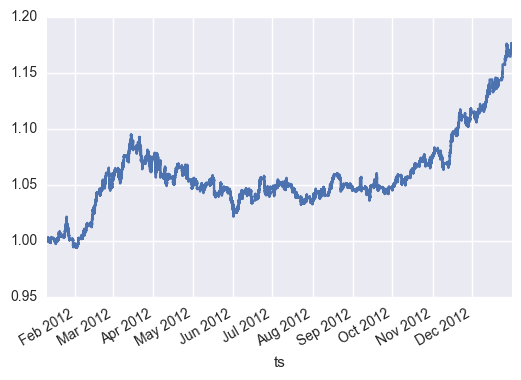

In [14]:

# load test dataset
X_test, Y_test, prices_test, fut_return_test = datasets.load(datasets.filename(dataset_name, lookahead, window, sym, 2012))
Y_test_pred = model.predict(X_test.as_matrix(), batch_size=1024)

performance_report("test",  prices_test,  lookahead, Y_test, Y_test_pred)
(fut_return_test.ix[Y_test_pred_class[:,0]]+1).cumprod().plot()

# TODO: demean fut_return..

------------------------------------------------------
test
f1-score: 0.521, mean future return: 0.017 bps


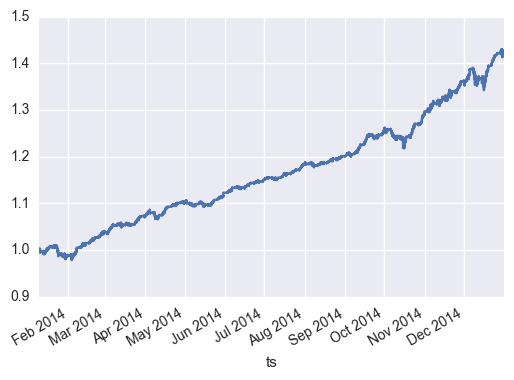

In [12]:
# random forest model
# load test dataset
X_test, Y_test, prices_test, fut_return_test = datasets.load(datasets.filename(dataset_name, lookahead, window, sym, 2014))
#X_test, Y_test, prices_test, fut_return_test = datasets.prepare_dataset2(df=datasets.random_ohlc(300000),lookahead=1, window=25)

performance_report("RF model",  prices_test,  lookahead, Y_test, rf_model.predict(X_test), cum_return_plot=True)
(fut_return_test.ix[Y_test_pred_class[:]]+1).cumprod().plot()


------------------------------------------------------
test
f1-score: 0.516, mean future return: 0.020 bps


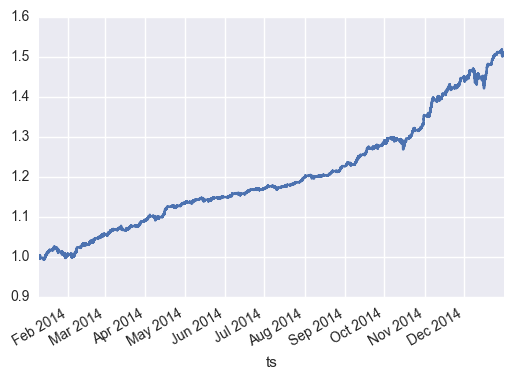

In [13]:
# adaboost model
# load test dataset
X_test, Y_test, prices_test, fut_return_test = datasets.load(datasets.filename(dataset_name, lookahead, window, sym, 2014))
#X_test, Y_test, prices_test, fut_return_test = datasets.prepare_dataset2(df=datasets.random_ohlc(300000),lookahead=1, window=25)
Y_test_pred = adb_model.predict(X_test)
Y_test_pred_class = utils.prediction_to_category2(Y_test_pred)
performance_report("test",  prices_test,  lookahead, Y_test, Y_test_pred_class)
(fut_return_test.ix[Y_test_pred_class[:]]+1).cumprod().plot()


In [ ]:
len(fut_return_test)